In [8]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['axes.titlesize'] = 18

In [101]:
monthly = pd.read_csv("frontier/monthlyinc1000.txt", names=['slot', 'value', 'inserted_at', 'pk'], delimiter='|')
monthly['inserted_at'] = pd.to_datetime(monthly['inserted_at'], format="%Y-%m-%d%H:%M:%S.%f")
monthly.head()

,slot,value,inserted_at,pk
0,5877441,4100751565914457,2023-02-25 19:28:24.879946,0xa1ee9e
1,5877441,3666426134683254,2023-02-25 19:28:25.068712,0xaa1488
2,5877441,4205695161447457,2023-02-25 19:28:25.138228,0xa1ee9e
3,5877441,4304797161447457,2023-02-25 19:28:25.403391,0xa1ee9e
4,5877441,3771369730216254,2023-02-25 19:28:25.414058,0xa85807


In [4]:
len(monthly)

72255

In [5]:
slots = list(set(monthly['slot'].values))
pks = list(set(monthly['pk'].values))
len(slots), len(pks)

(98, 70)

In [56]:
pkWeiPerMus = {}
for p in pks:
    pkWeiPerMus[p] = []

for sl in tqdm(slots[:]):
    slotdf = monthly[monthly['slot']==sl]
    for pk in pks[:]:
        pkdf = slotdf[slotdf['pk']==pk]
        diffsTime = np.asarray([v.total_seconds() * 1000000 for v in pkdf['inserted_at'].diff()])
        diffsVal = np.asarray([v for v in pkdf['value'].diff()])
        for i in range(1, len(diffsTime)):
            if diffsTime[i] <= 0:
                raise ValueError("negative time diff")
            if diffsVal[i] < 0:
                continue
            pkWeiPerMus[pk].append(diffsVal[i] / diffsTime[i])

100%|██████████| 98/98 [00:06<00:00, 16.27it/s]


In [57]:
total = []
for k in pkWeiPerMus.keys():
    total.extend(pkWeiPerMus[k])
total = np.asarray(total)
total.shape

(58596,)

In [59]:
total_plt = total[total > np.percentile(total, 5)]
total_plt = total[total < np.percentile(total, 95)]
total_plt.shape

(55666,)

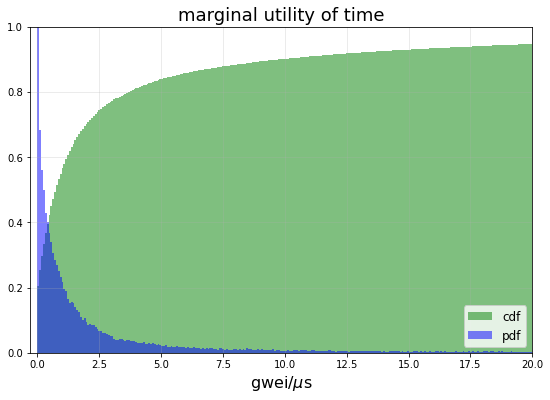

In [71]:
f, ax = plt.subplots(figsize=(9,6))

ax.hist(total_plt/int(1e9), bins=1000, color='g', alpha=0.5, cumulative=1, density=True, label='cdf')
ax.hist(total_plt/int(1e9), bins=1000, color='b', alpha=0.5, density=True, label='pdf')

ax.set_xlim(-0.3, 20)
ax.set_ylim(0, 1)
ax.set_xlabel('gwei/$\mu$s', size=16)
ax.set_title('marginal utility of time', size=18)
ax.legend(prop={'size': 12}, loc=4)
plt.show()

In [82]:
percs("gwei per \mu s", total/int(1e9))

gwei per \mu s & 0 & 3 & 20 & 74 & 961 & 19693 \\


In [81]:
def percs(label, arr):
    print('{} & '.format(label), end='')
    st = ''
    for i in [.50, .75, .90, 0.95, .99, .999]:
        st += str(int(np.quantile(arr, i)))
        st += " & "
    print(st[:-3] + ' \\\\')

## winner submission times

In [102]:
mwins = pd.read_csv("frontier/winningrecvd.txt", names=['slot', 'bh', 'received_at', 'eligible_at'], delimiter='|')
mwins['received_at'] = pd.to_datetime(mwins['received_at'], format="%Y-%m-%d%H:%M:%S.%f")
mwins['eligible_at'] = pd.to_datetime(mwins['eligible_at'], format="%Y-%m-%d%H:%M:%S.%f")
mwins.head()

,slot,bh,received_at,eligible_at
0,5992159,0x845b7b8844d4787da924b466c89e88d399ede24191f3...,2023-03-13 17:52:11.483072,2023-03-13 17:52:11.638520
1,5992160,0x7a17c8498b5cd6116b792095359e4d9dd2daa9726afd...,2023-03-13 17:52:24.239075,2023-03-13 17:52:24.508869
2,5992165,0xaaf01a06a1c7c73b5c1ade6e4b9fe22adfe283eacf0c...,2023-03-13 17:53:22.851942,2023-03-13 17:53:23.104399
3,5992167,0x1f18e6e2450b328fa548914b6cdcc41e09f64d6311ca...,2023-03-13 17:53:47.102979,2023-03-13 17:53:47.232045
4,5992169,0xf13d1bc828058e0b6150628330c39de5586e6c83e303...,2023-03-13 17:54:10.935878,2023-03-13 17:54:11.084660


In [103]:
len(mwins)

31273

In [104]:
mwins = mwins.sort_values('eligible_at', ascending=True).drop_duplicates('slot').sort_index()
mwins.head()

,slot,bh,received_at,eligible_at
0,5992159,0x845b7b8844d4787da924b466c89e88d399ede24191f3...,2023-03-13 17:52:11.483072,2023-03-13 17:52:11.638520
1,5992160,0x7a17c8498b5cd6116b792095359e4d9dd2daa9726afd...,2023-03-13 17:52:24.239075,2023-03-13 17:52:24.508869
2,5992165,0xaaf01a06a1c7c73b5c1ade6e4b9fe22adfe283eacf0c...,2023-03-13 17:53:22.851942,2023-03-13 17:53:23.104399
3,5992167,0x1f18e6e2450b328fa548914b6cdcc41e09f64d6311ca...,2023-03-13 17:53:47.102979,2023-03-13 17:53:47.232045
4,5992169,0xf13d1bc828058e0b6150628330c39de5586e6c83e303...,2023-03-13 17:54:10.935878,2023-03-13 17:54:11.084660


In [105]:
len(mwins)

27397

In [107]:
mwins['slot_boundary'] = np.asarray([pd.Timestamp(x).round(freq='12S') for x in mwins['received_at'].values])
mwins['diff'] = [v.total_seconds() for v in mwins['slot_boundary'] - mwins['received_at']]
mwins.head()

,slot,bh,received_at,eligible_at,slot_boundary,diff
0,5992159,0x845b7b8844d4787da924b466c89e88d399ede24191f3...,2023-03-13 17:52:11.483072,2023-03-13 17:52:11.638520,2023-03-13 17:52:12,0.516928
1,5992160,0x7a17c8498b5cd6116b792095359e4d9dd2daa9726afd...,2023-03-13 17:52:24.239075,2023-03-13 17:52:24.508869,2023-03-13 17:52:24,-0.239075
2,5992165,0xaaf01a06a1c7c73b5c1ade6e4b9fe22adfe283eacf0c...,2023-03-13 17:53:22.851942,2023-03-13 17:53:23.104399,2023-03-13 17:53:24,1.148058
3,5992167,0x1f18e6e2450b328fa548914b6cdcc41e09f64d6311ca...,2023-03-13 17:53:47.102979,2023-03-13 17:53:47.232045,2023-03-13 17:53:48,0.897021
4,5992169,0xf13d1bc828058e0b6150628330c39de5586e6c83e303...,2023-03-13 17:54:10.935878,2023-03-13 17:54:11.084660,2023-03-13 17:54:12,1.064122


In [120]:
percs = [(int(i*100), np.quantile(mwins['diff'], i)) for i in [.50, .90, .99]]
percs

[(50, 0.864746), (90, 1.3146894000000002), (99, 1.8900897600000028)]

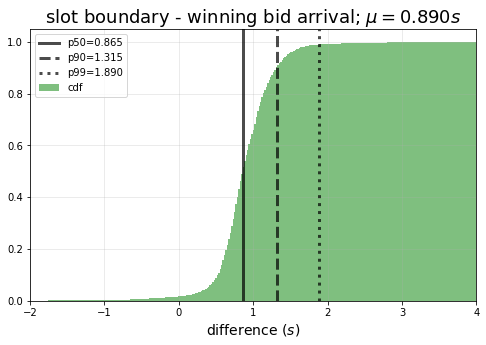

In [127]:
f, ax = plt.subplots(figsize=(8,5))

bins = np.histogram(mwins['diff'], bins=600)[1]
# ax.hist(mwins['diff'], bins, color='b', alpha=0.5, cumulative=0, density=True, label='pdf')
ax.hist(mwins['diff'], bins, color='g', alpha=0.5, cumulative=1, density=True, label='cdf')
linestyle = ['-', '--', ':']
for i, v in enumerate(percs):
    ax.axvline(v[1], label='p{}={:0.3f}'.format(v[0], v[1]), color='k', linestyle=linestyle[i], linewidth=3, alpha=0.7)

ax.set_xlim(-2,4)
ax.set_xlabel('difference $(s)$', size=14)
ax.set_title('slot boundary - winning bid arrival; $\mu={:0.3f}s$'.format(mwins['diff'].mean()), size=18)
plt.legend()
plt.show()

## simulation durations 

In [129]:
nopts = pd.read_csv('rollout/big/noptsubs.txt', delimiter="|")
nopts['received_at'] = pd.to_datetime(nopts['received_at'], format="%Y-%m-%d%H:%M:%S.%f")
# nopts['slot_boundary'] = np.asarray([pd.Timestamp(x).round(freq='12S') for x in nopts['received_at'].values])
nopts.head()

,received_at,optimistic_submission,decode_duration,prechecks_duration,simulation_duration,redis_update_duration,total_duration,substring
0,2023-03-13 17:57:45.774553,f,12410,1786,75578,6903,96678,0x978a35
1,2023-03-13 17:57:45.698805,f,89843,1617,105741,6568,203771,0xa82f9a
2,2023-03-13 17:57:45.810121,f,7900,1768,96445,7302,113417,0x84b02b
3,2023-03-13 17:57:43.602490,f,90470,1353,98227,5276,195328,0xa1dead
4,2023-03-13 17:57:43.675843,f,87590,1465,101181,5469,195707,0xa85807


In [133]:
len(nopts)

1000000

In [130]:
12410 + 1786 + 75578 + 6903

96677

In [138]:
nopts_plot = nopts[nopts['total_duration'] < np.quantile(nopts['total_duration'].values, 0.99)]
len(nopts_plot)

990000

In [166]:
np.quantile(nopts['simulation_duration'].values, 0.999)

1592421.026000001

In [168]:
nopts['decode_duration'].mean(), nopts['prechecks_duration'].mean(),nopts['simulation_duration'].mean(),nopts['redis_update_duration'].mean()

(73041.164332, 17930.121351, 142992.88085, 35826.475345)

In [184]:
yopts['redis_update_duration'].mean(), yopts['redis_update_duration'].mean() / yopts['total_duration'].mean(), 

(25923.84881855749, 0.26330497914869067)

In [170]:
73041.164332 + 17930.121351 + 142992.88085 + 35826.475345

269790.641878

In [185]:
yopts['total_duration'].mean()

98455.59663312732

In [172]:
yopts['decode_duration'].mean(), yopts['prechecks_duration'].mean(),yopts['simulation_duration'].mean(),yopts['redis_update_duration'].mean()

(53252.13336907648, 19247.562639861502, 30.55739570621766, 25923.84881855749)

In [173]:
yopts['total_duration'].mean()

98455.59663312732

In [174]:
53252.13336907648 + 19247.562639861502 + 30.55739570621766 + 25923.84881855749

98454.10222320168

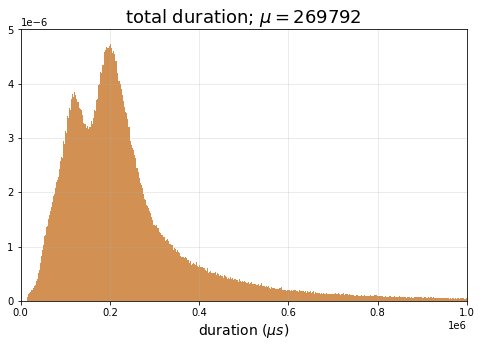

In [203]:
f, ax = plt.subplots(figsize=(8,5))
bins = np.histogram(nopts_plot['total_duration'], bins=1000)[1]
# ax.hist(nopts_plot['simulation_duration'], bins=bins, color='darkviolet', alpha=0.9, density=True, 
#         label='simulation duration $(\mu = {:0.0f})$'.format(nopts['simulation_duration'].values.mean()))
ax.hist(nopts_plot['total_duration'], bins=bins, color='peru', alpha=0.9, density=True, 
        label='total duration $(\mu = {:0.0f})$'.format(nopts['total_duration'].values.mean()))
ax.set_xlim(0, int(1e6))
# ax.legend(loc=0)
ax.set_xlabel('duration $(\mu s)$', size=14)
# ax.set_title('non-optimistic block submission durations', size=16)
ax.set_title('total duration; $\mu = {:0.0f}$'.format(nopts['total_duration'].values.mean()), size=18)
plt.show()

In [191]:
len(nopts[nopts['simulation_duration'] > int(1e6)]) / len(nopts) 

0.004962

In [192]:
percs = [(int(i*100), np.quantile(nopts['simulation_duration'], i)) for i in [.50, .90, .99]]
percs

[(50, 113377.0), (90, 218973.0), (99, 744570.2900000003)]

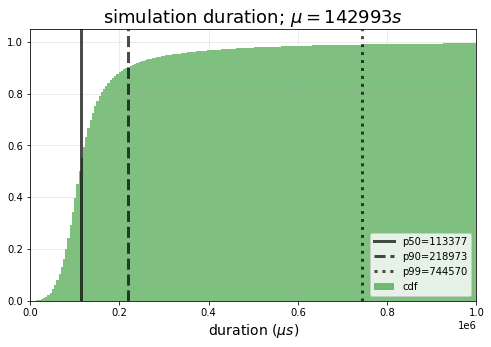

In [199]:
f, ax = plt.subplots(figsize=(8,5))

bins = np.histogram(nopts['simulation_duration'], bins=600)[1]
# ax.hist(mwins['diff'], bins, color='b', alpha=0.5, cumulative=0, density=True, label='pdf')
ax.hist(nopts['simulation_duration'], bins, color='g', alpha=0.5, cumulative=1, density=True, label='cdf')
linestyle = ['-', '--', ':']
for i, v in enumerate(percs):
    ax.axvline(v[1], label='p{}={:0.0f}'.format(v[0], v[1]), color='k', linestyle=linestyle[i], linewidth=3, alpha=0.7)

ax.set_xlim(0,int(1e6))
ax.set_xlabel('duration $(\mu s)$', size=14)
ax.set_title('simulation duration; $\mu={:0.0f}s$'.format(nopts['simulation_duration'].mean()), size=18)
plt.legend(loc=4)
plt.show()

## opt submissions

In [154]:
yopts = pd.read_csv('rollout/big/optsubs.txt', delimiter="|")
yopts['received_at'] = pd.to_datetime(yopts['received_at'], format="%Y-%m-%d%H:%M:%S.%f")
# nopts['slot_boundary'] = np.asarray([pd.Timestamp(x).round(freq='12S') for x in nopts['received_at'].values])
yopts.head()

,received_at,optimistic_submission,decode_duration,prechecks_duration,simulation_duration,redis_update_duration,total_duration,substring
0,2023-03-17 12:12:33.673550,t,12062,1407,11,5999,19481,0xb33333
1,2023-03-17 12:12:20.659166,t,101735,1449,7,5578,108770,0x83d349
2,2023-03-17 12:12:20.822450,t,11241,2096,10,6061,19409,0x978a35
3,2023-03-17 12:12:21.083129,t,135937,1408,10,8629,145986,0x83d349
4,2023-03-17 12:12:22.254343,t,234029,1672,7,5794,241504,0x83d349


In [155]:
len(yopts)

912063

In [158]:
12062 + 11 + 5999 + 1407

19479

In [159]:
yopts_plot = yopts[yopts['total_duration'] < np.quantile(yopts['total_duration'].values, 0.99)]
len(nopts_plot)

990000

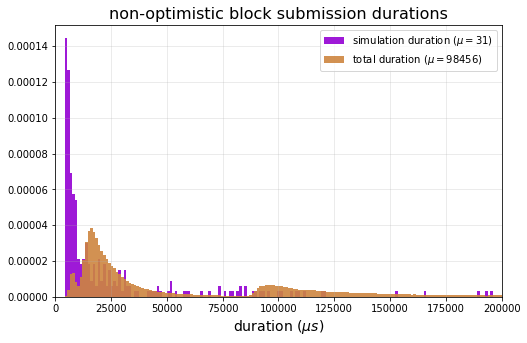

In [161]:
f, ax = plt.subplots(figsize=(8,5))
bins = np.histogram(yopts_plot['total_duration'], bins=1000)[1]
ax.hist(yopts_plot['simulation_duration'], bins=bins, color='darkviolet', alpha=0.9, density=True, 
        label='simulation duration $(\mu = {:0.0f})$'.format(yopts['simulation_duration'].values.mean()))
ax.hist(yopts_plot['total_duration'], bins=bins, color='peru', alpha=0.9, density=True, 
        label='total duration $(\mu = {:0.0f})$'.format(yopts['total_duration'].values.mean()))
ax.set_xlim(0, int(2e5))
ax.legend(loc=0)
ax.set_xlabel('duration $(\mu s)$', size=14)
ax.set_title('non-optimistic block submission durations', size=16)
plt.show()

## block size & latency

In [206]:
pdurs = pd.read_csv('frontier/payload_durs.txt', delimiter='|', names=['bytes', 'decode_duration', 'pubkey'])
pdurs.head()

,bytes,decode_duration,pubkey
0,55660,12369,0xa971c4ee4ac5d47e0fb9e16be05981bfe51458f14c06...
1,52714,31733,0x83d3495a2951065cf19c4d282afca0a635a39f6504bd...
2,56012,10890,0xa4fb63c2ceeee73d1f1711fadf1c5357ac98cecb999d...
3,53879,124424,0xa66f3abc04df65c16eb32151f2a92cb7921efdba4c25...
4,51754,255603,0x8cb3cb2fdc996d14bf30bc56c94d93f250245cfd4578...


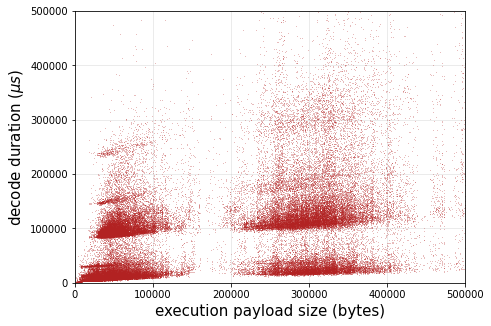

In [207]:
f, ax = plt.subplots(figsize=(7,5))
ax.plot(pdurs['bytes'], pdurs['decode_duration'], color='firebrick', marker=',', alpha=0.3, linestyle='None')
ax.set_ylim(0, int(5e5))
ax.set_xlim(0, int(5e5))
# ax.set_xticks(np.arange(0, int(5e5), int(1e5)))
# ax.set_xticklabels(np.arange(0, int(5e5), int(1e5)))
ax.set_xlabel('execution payload size (bytes)', size=15)
ax.set_ylabel('decode duration $(\mu s)$', size=15)
plt.show()

In [219]:
tops = pdurs['pubkey'].value_counts()[:10].index
tops

Index(['0xa66f3abc04df65c16eb32151f2a92cb7921efdba4c25ab61b969a2af24b61508783ceb48175ef252ec9f82c6cdf8d8fd',
       '0x978a35c39c41aadbe35ea29712bccffb117cc6ebcad4d86ea463d712af1dc80131d0c650dc29ba29ef27c881f43bd587',
       '0xb67eaa5efcfa1d17319c344e1e5167811afbfe7922a2cf01c9a361f465597a5dc3a5472bd98843bac88d2541a78eab08',
       '0x8bc8d110f8b5207e7edc407e8fa033937ddfe8d2c6f18c12a6171400eb6e04d49238ba2b0a95e633d15558e6a706fbe4',
       '0x96a59d355b1f65e270b29981dd113625732539e955a1beeecbc471dd0196c4804574ff871d47ed34ff6d921061e9fc27',
       '0x83d3495a2951065cf19c4d282afca0a635a39f6504bd76282ed0138fe28680ec60fa3fd149e6d27a94a7d90e7b1fb640',
       '0xb5d883565500910f3f10f0a2e3a031139d972117a3b67da191ff93ba00ba26502d9b65385b5bca5e7c587273e40f2319',
       '0xa4fb63c2ceeee73d1f1711fadf1c5357ac98cecb999d053be613f469a48f7416999a4da35dd60a7824478661399e6772',
       '0xa971c4ee4ac5d47e0fb9e16be05981bfe51458f14c06b7a020304099c23d2d9952d4254cc50f291c385d15e7cae0cf9d',
       '0xb194b2b8e

In [222]:
pk_durs = {}
for i in tops:
    pk_durs[i] = pdurs[pdurs['pubkey']==i]

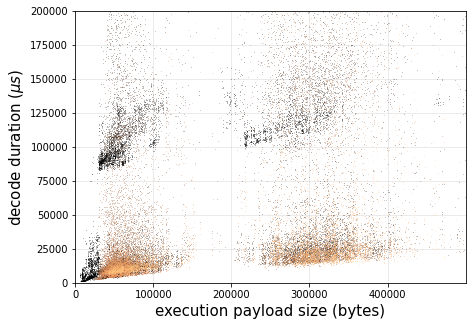

In [225]:
f, ax = plt.subplots(figsize=(7,5))
colors = plt.cm.copper(np.linspace(0, 1, 10))
for i,pk in enumerate(pk_durs):
    val = pk_durs[pk]
    ax.plot(val['bytes'], val['decode_duration'], color=colors[i], marker=',', alpha=0.3, linestyle='None')
ax.set_ylim(0, int(2e5))
ax.set_xlim(0, int(5e5))
ax.set_xticks(np.arange(0, int(5e5), int(1e5)))
ax.set_xticklabels(np.arange(0, int(5e5), int(1e5)))
ax.set_xlabel('execution payload size (bytes)', size=15)
ax.set_ylabel('decode duration $(\mu s)$', size=15)
plt.show()

In [258]:
tops[2]

'0xb67eaa5efcfa1d17319c344e1e5167811afbfe7922a2cf01c9a361f465597a5dc3a5472bd98843bac88d2541a78eab08'

In [259]:
tops[1]

'0x978a35c39c41aadbe35ea29712bccffb117cc6ebcad4d86ea463d712af1dc80131d0c650dc29ba29ef27c881f43bd587'

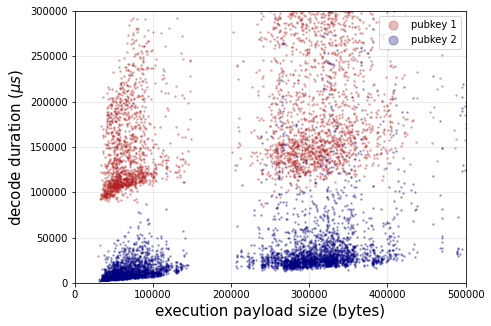

In [264]:
f, ax = plt.subplots(figsize=(7,5))
# colors = plt.cm.copper(np.linspace(0, 1, 10))
val = pk_durs[tops[2]]
ax.plot(val['bytes'], val['decode_duration'], color='firebrick', marker='.', alpha=0.3, linestyle='None', 
        markersize=3, label='pubkey 1')

val = pk_durs[tops[1]]
ax.plot(val['bytes'], val['decode_duration'], color='navy', marker='.', alpha=0.3, linestyle='None', 
        markersize=3, label='pubkey 2')
ax.set_ylim(0, int(3e5))
ax.set_xlim(0, int(5e5))
# ax.set_xticks(np.arange(0, int(5e5), int(1e5)))
# ax.set_xticklabels(np.arange(0, int(5e5), int(1e5)))
ax.set_xlabel('execution payload size (bytes)', size=15)
ax.set_ylabel('decode duration $(\mu s)$', size=15)
lgnd = ax.legend(markerscale=6)
plt.show()

In [265]:
pk1 = pk_durs[tops[2]]
pk2 = pk_durs[tops[1]]

In [266]:
normalized1 = pk1['decode_duration'] / pk1['bytes']
normalized2 = pk2['decode_duration'] / pk2['bytes']

In [274]:
normalized1.mean()

1.32258861178476

In [273]:
normalized2.mean()

0.17164546399480177

In [267]:
len(normalized1), len(normalized2)

(4280, 5133)

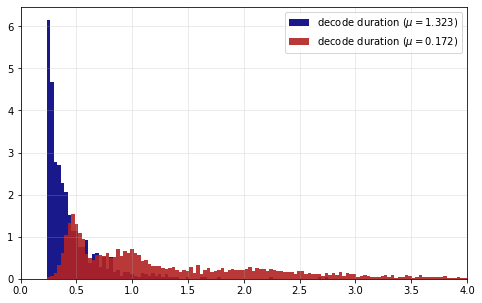

In [276]:
f, ax = plt.subplots(figsize=(8,5))
bins = np.histogram(normalized1, bins=300)[1]
ax.hist(normalized2, bins=bins, color='navy', alpha=0.9, density=True, 
        label='decode duration $(\mu = {:0.3f})$'.format(normalized1.mean()))
ax.hist(normalized1, bins=bins, color='firebrick', alpha=0.9, density=True, 
        label='decode duration $(\mu = {:0.3f})$'.format(normalized2.mean()))
ax.set_xlim(0, 4)
ax.legend(loc=0)
# ax.set_xlabel('duration $(\mu s)$', size=14)
# ax.set_title('non-optimistic block submission durations', size=16)
plt.show()